In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta


import xarray as xr
import matplotlib.pyplot as plt
import sys
sys.path.append(r'C:\Users\ruro\OneDrive - Boskalis\Documents\python\OSSI')
from KNMI_readers import read_knmi_uurgeg


import puv



In [2]:
def ossi_data_reader(datafolder):
    '''
    author: Paul van Wiechen

    Function to read all WLOG_XXX files in a certain subfolder.
    Make sure that only WLOG_XXX files are in this folder and no other files.
    Only WLOG_XXX files with minimally 2 rows are appended to the dataframe.
    A correct WLOG_XXX file should contain a first line with OSSI configuration, and a second line (third row) with starting time
    Timestep and sampling frequency are retrieved from the first row. Starting time from the next row
    Returns a dataframe with a time column and pressure column in dbars
    '''

    ossi = pd.DataFrame({
        't': [],
        'p': []})

    directory = str(datafolder)

    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)

        # checking if it is a file
        if os.path.isfile(f):
            print('Currently concatenating file ' + f)
            ossi_raw = pd.read_csv(f, header=None, nrows=4, sep=',')
            if len(ossi_raw.index) > 2:
                t_0 = datetime(int(str(20) + ossi_raw[0][1][1:]), int(ossi_raw[1][1][1:]), int(ossi_raw[2][1][1:]),
                               int(ossi_raw[3][1][1:]), int(ossi_raw[4][1][1:]), int(ossi_raw[5][1][1:]))
                dt = 1 / float(ossi_raw[6][0][1:])
                ossi_tot = pd.read_csv(f, skiprows=3, usecols=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], header=None,
                                       sep=',', skipinitialspace=True).to_numpy().flatten()
                ossi_temp = pd.DataFrame({
                    't': np.array([t_0 + timedelta(seconds=dt * i) for i in range(len(ossi_tot))]),
                    'p': ossi_tot})

                ossi_temp.dropna(inplace=True)
                ossi_temp['p'] = ossi_temp['p'] * 1e5  # Bar to Pa

                ossi = pd.concat([ossi, ossi_temp], ignore_index=True)

    ossi['p'] = pd.to_numeric(ossi['p'])
    ossi['t'] = pd.to_datetime(ossi['t'])

    return ossi.set_index('t')


In [3]:
experimentFolder = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\OSSI\OSSI_02_data"    #Grand map
dfp = ossi_data_reader(os.path.join(experimentFolder,'Ossi02_25-27'))                                                       #specific map for data OSSI

instrument = 'OSSI_02'          # Specific name instrument
sf = 10                          # Hz, sampling frequency
xRD = 117221.8                   # location x-coord
yRD = 559793.1                   # location y-coord
serial_number = '18.09.00.08'    # unique serial number

rho = 1028      # Density of sea water
g = 9.81        # Gravitational force
zb = -1.43      # Height of sea bed
zi = -1.30      # Height of instrument

knmiFile = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\uurgeg_330_2021-2030.txt"

ds = dfp.to_xarray()
ds['p'] = ds.p.astype('int32')
ds.p.attrs = {'long_name': 'pressure', 'units': 'Pa'}

# add global attribute metadata
ds.attrs = {
    'Conventions': 'CF-1.6',
    'name': '{}'.format(instrument),
    'instrument': '{}'.format(instrument),
    'instrument type': 'OSSI',
    'instrument serial number': '{}'.format(serial_number),
    'epsg': 28992,
    'x': xRD,
    'y': yRD,
    'sf': 10,
    'time zone': 'UTC+2',
    'summary': 'SEDMEX field campaign',
    'contact person': 'Marlies van der Lugt',
    'emailadres': 'm.a.vanderlugt@tudelft.nl',
    'construction datetime': datetime.now().strftime("%d-%b-%Y (%H:%M:%S)"),
    'version': 'v1',
    'version comments': 'constructed with xarray'}

#if nothing else, at least specify lossless zlib compression
comp = dict(zlib=True, complevel=5)
ds.encoding = {var: comp for var in ds.data_vars}

# save to file
if not os.path.isdir(os.path.join(experimentFolder,'raw_netcdf')):
    os.mkdir(os.path.join(experimentFolder,'raw_netcdf'))
ncFilePath = os.path.join(experimentFolder, 'raw_netcdf', instrument + '.nc')
ds.to_netcdf(ncFilePath)


Currently concatenating file C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\OSSI\OSSI_02_data\Ossi02_25-27\WLOG_001.CSV
Currently concatenating file C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\OSSI\OSSI_02_data\Ossi02_25-27\WLOG_002.CSV


C:\Users\ruro\AppData\Local\Temp\ipykernel_32184\1382462514.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ossi = pd.concat([ossi, ossi_temp], ignore_index=True)


Currently concatenating file C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\OSSI\OSSI_02_data\Ossi02_25-27\WLOG_003.CSV
Currently concatenating file C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\OSSI\OSSI_02_data\Ossi02_25-27\WLOG_004.CSV


In [4]:
ds

<xarray.Dataset> Size: 49MB
Dimensions:  (t: 4061801)
Coordinates:
  * t        (t) datetime64[ns] 32MB 2024-09-25T12:31:00 ... 2024-09-27T20:57...
Data variables:
    p        (t) int32 16MB 1576 1657 1616 1598 1608 ... 1652 1651 1651 1651
Attributes: (12/16)
    Conventions:               CF-1.6
    name:                      OSSI_02
    instrument:                OSSI_02
    instrument type:           OSSI
    instrument serial number:  18.09.00.08
    epsg:                      28992
    ...                        ...
    summary:                   SEDMEX field campaign
    contact person:            Marlies van der Lugt
    emailadres:                m.a.vanderlugt@tudelft.nl
    construction datetime:     18-Nov-2024 (09:22:33)
    version:                   v1
    version comments:          constructed with xarray

In [5]:
dataFile = os.path.join(experimentFolder,'raw_netcdf', instrument +'.nc')
ds0 = xr.open_dataset(dataFile)
instr = ds0.instrument

# correct for the air pressure fluctuations and drift in the instrument
# first we load the data and add it to the dataset
dfp = read_knmi_uurgeg(knmiFile, 330)           # Adjust station number

dt = ((ds0.t[1] - ds0.t[0]) / np.timedelta64(1, 's')).values # target frequency

pAir = dfp['P'].to_xarray().sel(t=slice(ds0.t.min(), ds0.t.max())).resample({'t': '{}S'.format(dt)}).interpolate('linear')
ds0['pAir'] = pAir.sel(t=slice(ds0.t.min(), ds0.t.max()))

pAir = dfp['P'].to_xarray().sel(t=slice(ds0.t.min(), ds0.t.max())).resample({'t': '{}S'.format(dt)}).interpolate('linear')
ds0['pAir'] = pAir.sel(t=slice(ds0.t.min(), ds0.t.max()))

############
first_real_value = ds0['pAir'].dropna(dim='t', how='all').isel(t=0)
ds0['dpAir'] = ds0['pAir'] - first_real_value
# ds0['dpAir'] = ds0['pAir']
##########
# we correct for drift in air pressure, nothing else
# ds0['dpAir'] = ds0['pAir'] - ds0['pAir'].isel(t=0)

# correct the pressure signal with dpAir and with drift in instrument pressure
ds0['pc'] = ds0['p'] -ds0['p'].min() - ds0['dpAir']
# ds0['pc'] = ds0['p'] -ds0['p'].min()
ds0['pc'].attrs = {'units': 'Pa + NAP', 'long_name': 'pressure', 'comments': 'drift in air pressure is corrected'}

# -----------------------------------------------------------------------------
# reshape to one row per burst in data array
pt = ds0.pc.values
nSamples = len(pt)
dt = ds0.isel(t=1).t - ds0.isel(t=0).t
sf = np.timedelta64(1, 's') / dt.values

burstDuration = pd.Timedelta('1200S')
burstLength = int(burstDuration / dt)
nBursts = int(np.floor(nSamples / burstLength))

pt = pt[:nBursts * burstLength]
t = ds0.t[::burstLength]
t = t[:nBursts]
N = (ds0.t.values[:burstLength] - ds0.t.values[0]) / np.timedelta64(1, 's')
# pdb.set_trace()

# --------------------------------------------------------------------------
# cast into a 2D array
ds = xr.Dataset(data_vars={},
                coords={'t': t, 'N': N})
# copy all data over into this new structure
ds['p'] = (('t', 'N'), pt.reshape((nBursts, burstLength)))
ds['zi'] = zi
ds['zb'] = zb
ds['sf'] = sf

# remove all bursts where instrument fell dry
ds['p'] = ds.p.where(ds.p.std(dim='N') > 70)

# --------------------------------------------------------------------------
# pdb.set_trace()
ds['p'].attrs = {'units': 'Pa +NAP', 'long_name': 'pressure', 'comments': 'corrected for air pressure'}
ds['zi'].attrs = {'units': 'm+NAP', 'long_name': 'zi'}
ds['zb'].attrs = {'units': 'm+NAP', 'long_name': 'zb'}
ds['sf'].attrs = {'units': 'Hz', 'long_name': 'sampling frequency'}
ds.attrs = ds0.attrs
ds.attrs['summary'] = 'SEDMEX field campaign, pressure corrected for air pressure and cast in bursts of 10 minutes'
ds['name'] = instr
if not os.path.isdir(os.path.join(experimentFolder, 'QC')):
    os.mkdir(os.path.join(experimentFolder,'QC'))
ncFilePath = os.path.join(experimentFolder, 'QC', instr + '.nc')
ds.to_netcdf(ncFilePath)

c:\Users\ruro\AppData\Local\Programs\Python\Python39\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
c:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\OSSI\KNMI_readers.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  t0 = pd.to_datetime(knmi.iloc[0]['YYYYMMDD'],format='%Y%m%d')+pd.Timedelta('{}H'.format(knmi.iloc[0]['HH']))
c:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\OSSI\KNMI_readers.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  t = pd.date_range(t0.to_datetime64(),periods=len(knmi),freq='1H')
c:\Users\ruro\AppData\Local\Programs\Python\Python39\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'S' is deprecated and will be removed in

<xarray.Dataset> Size: 33MB
Dimensions:  (t: 169, N: 24000)
Coordinates:
  * t        (t) datetime64[ns] 1kB 2024-09-25T12:31:00 ... 2024-09-27T20:32:...
  * N        (N) float64 192kB 0.0 0.05 0.1 0.15 ... 1.2e+03 1.2e+03 1.2e+03
Data variables:
    p        (t, N) float64 32MB nan nan nan nan nan nan ... nan nan nan nan nan
    zi       float64 8B -1.3
    zb       float64 8B -1.43
    sf       float64 8B 20.0
    name     <U7 28B 'OSSI_02'
Attributes: (12/16)
    Conventions:               CF-1.6
    name:                      OSSI_02
    instrument:                OSSI_02
    instrument type:           OSSI
    instrument serial number:  18.09.00.08
    epsg:                      28992
    ...                        ...
    summary:                   SEDMEX field campaign, pressure corrected for ...
    contact person:            Marlies van der Lugt
    emailadres:                m.a.vanderlugt@tudelft.nl
    construction datetime:     18-Nov-2024 (09:22:33)
    version:                   v1
    version comments:          constructed with xarray

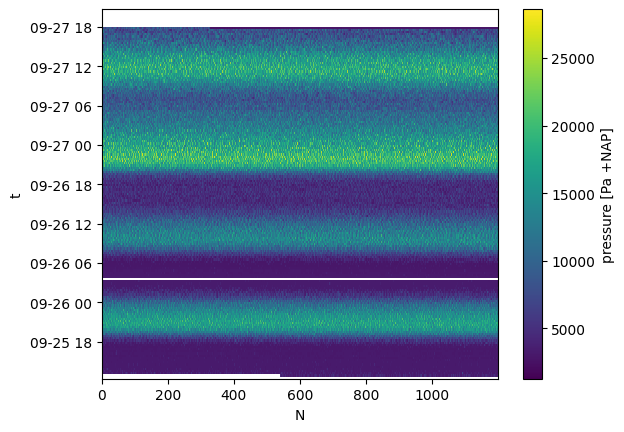

In [6]:
ds.p.plot()
ds

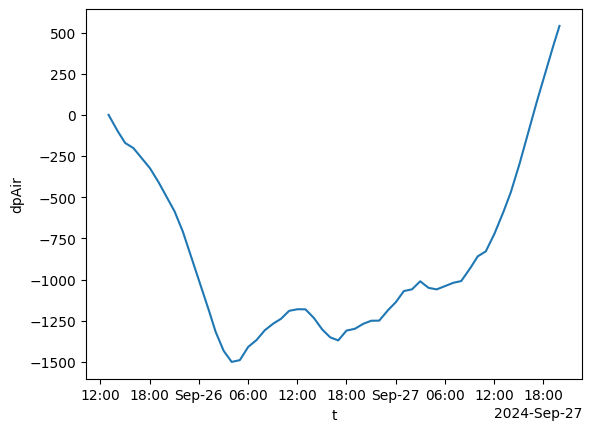

In [7]:
# ds0.dpAir.plot()
ds0.dpAir.plot()

In [17]:
# %% input specification
# experimentFolder = r'c:\Users\marliesvanderl\phd\vakbegeleiding\CIE5318\2022\OSSI\data'
instrFile = os.path.join(experimentFolder,'QC', instrument +'.nc')
ncOutFile = os.path.join(experimentFolder,'tailored', instrument +'.nc')

# frequency resolution in fourier space
fresolution = 0.02925
# fresolution = 0.03125

# %% load the raw data from netcdf
ds0 = xr.open_dataset(instrFile)

#let's remove the bursts where there are only nans
ds0 = ds0.dropna(dim='t')

# make a new dataset that has an extra dimension to accomodate for the frequency axis
ds = xr.Dataset(data_vars={},
                coords={'t': ds0.t.values,
                        'N': ds0.N.values,
                        'f': np.arange(0, ds0.sf.values / 2, fresolution)})
ds['f'].attrs = {'units': 'Hz'}
ds.attrs = ds0.attrs

# put all variables in this new dataset
for key in ds0.data_vars:
    ds[key] = ds0[key]

# extract sampling frequency as explicit variable
sf = ds.f.values

# compute water depth
ds['h'] = (ds['p']/rho/g + ( ds['zi']-ds['zb'] )).mean(dim='N')
ds['h'].attrs = {'long_name': 'mean water level', 'units': 'm+NAP'}

# %% do several wave statistics computations, only based on pressure
ufunc = lambda x, h: puv.attenuation_corrected_wave_spectrum(
    'pressure',
    ds.sf.values, x, h,
    ds.zi.values,
    ds.zb.values,
    fresolution=fresolution)

fx, ds['vy'] = xr.apply_ufunc(ufunc,
                              ds['p'], ds['h'],
                              input_core_dims=[['N'], []],
                              output_core_dims=[['f'], ['f']],
                              vectorize=True)
ds['vy'].attrs = {'units': 'm2/Hz', 'long_name': 'spectral density'}

ufunc = lambda vy: puv.get_peak_frequency(ds.f.values, vy)
ds['fp'] = xr.apply_ufunc(ufunc,
                          ds['vy'],
                          input_core_dims=[['f']],
                          output_core_dims=[[]],
                          vectorize=True)


ufunc = lambda vy, fp: puv.compute_wave_params(ds.f.values, vy, fmin=0.5 * fp, fmax=5)
ds['Hm0'], ds['Tp'], ds['Tm01'], ds['Tm02'], ds['Tmm10'], ds['Tps'] = xr.apply_ufunc(ufunc,
                                                                          ds['vy'], ds['fp'],
                                                                          input_core_dims=[['f'], []],
                                                                          output_core_dims=[[], [], [], [], [], []],
                                                                          vectorize=True)

# Calculate Hm0 for low frequency waves
ufunc = lambda vy, fp: puv.compute_wave_params(ds.f.values, vy, fmin= 10E-4, fmax=0.05)
ds['vylf'] = ds.vy.where(ds.f <= 0.05)
ds['Hm0_LF'], _, _, _, _, _ = xr.apply_ufunc(ufunc,
                                             ds['vy'], ds['fp'],
                                             input_core_dims=[['f'], []],
                                             output_core_dims=[[], [], [], [], [], []],
                                             vectorize=True)

# Calculate Hm0 for high frequency waves
ufunc = lambda vy, fp: puv.compute_wave_params(ds.f.values, vy, fmin=0.05, fmax=5)
# ds['vyhf'] = ds.vy.where(ds.f >= 0.05)
ds['Hm0_HF'], _, _, _, _, _ = xr.apply_ufunc(ufunc,
                                             ds['vy'], ds['fp'],
                                             input_core_dims=[['f'], []],
                                             output_core_dims=[[], [], [], [], [], []],
                                             vectorize=True)

ds['Hm0'].attrs = {'units': 'm', 'long_name': 'significant wave height',
                   'computation': 'computed between fmin=0.5fp and fmax=5'}
ds['Hm0_LF'].attrs = {'units': 'm', 'long_name': 'significant wave height for low frequency waves (long waves)',
                   'computation': 'computed between fmin=0.01 and fmax=0.05'}
ds['Hm0_HF'].attrs = {'units': 'm', 'long_name': 'significant wave height for high frequency waves (short waves)',
                   'computation': 'computed between fmin=0.05 and fmax=5'}
ds['Tp'].attrs = {'units': 's', 'long_name': 'peak wave period',
                  'computation': 'computed between fmin=0.5fp and fmax=5'}
ds['Tm01'].attrs = {'units': 's', 'long_name': 'mean wave period',
                    'computation': 'computed between fmin=0.5fp and fmax=5'}
ds['Tm02'].attrs = {'units': 's', 'long_name': 'mean wave period',
                    'computation': 'computed between fmin=0.5fp and fmax=5'}
ds['Tmm10'].attrs = {'units': 's', 'long_name': 'mean wave period',
                     'computation': 'computed between fmin=0.5fp and fmax=5'}
ds['Tps'].attrs = {'units': 's', 'long_name': 'smoothed peak period', 
                     'computation': 'computed between fmin=0.5fp and fmax=5'}

# %% write to file
# we strip all information on burst scale from the dataset to reduce size (and this info is already present in the raw_netcdf version of the data)
dsTailored = ds.drop_dims('N')
if not os.path.isdir(os.path.join(experimentFolder,'tailored')):
    os.mkdir(os.path.join(experimentFolder,'tailored'))
ncFilePath = os.path.join(experimentFolder, 'tailored', ds0.instrument + '.nc')
dsTailored.to_netcdf(ncFilePath)



c:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\OSSI\puv.py:351: RuntimeWarning: overflow encountered in cosh
  Sw = np.cosh(k*h)/np.cosh(k*elev)
c:\Users\ruro\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  output[index] = result


<xarray.DataArray 'vylf' (t: 158, f: 342)> Size: 432kB
array([[0.        , 0.00845882,        nan, ...,        nan,        nan,
               nan],
       [0.        , 0.00339085,        nan, ...,        nan,        nan,
               nan],
       [0.        , 0.00182857,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.        , 0.17330416,        nan, ...,        nan,        nan,
               nan],
       [0.        , 0.22711653,        nan, ...,        nan,        nan,
               nan],
       [0.        , 0.27073195,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * t        (t) datetime64[ns] 1kB 2024-09-25T13:11:00 ... 2024-09-27T17:52:...
  * f        (f) float64 3kB 0.0 0.02925 0.0585 0.08775 ... 9.916 9.945 9.974
Attributes:
    units:      m2/Hz
    long_name:  spectral density


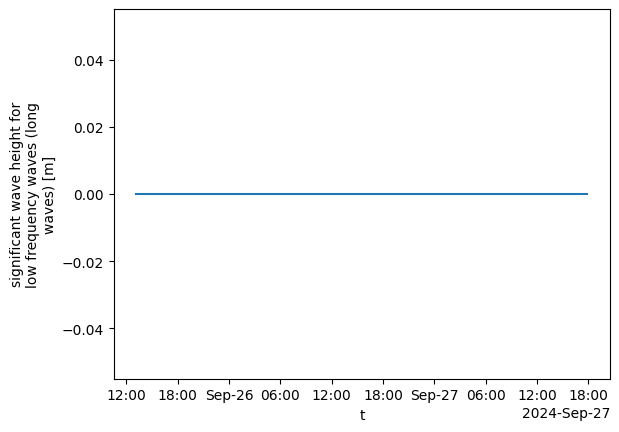

In [9]:
ds.Hm0_LF.plot()
print(ds.vylf)

In [16]:
def calcmoments(fx, vy, fmin=-9999, fmax=9999):
    """
    Calculates spectral moments from frequency and power density data.
    """    
    if np.min(np.diff(fx)) <= 0:
        raise ValueError('fx should be increasing')
    
    imin = bisect(fx, fmin)
    imax = bisect(fx, fmax)
    
    # Select frequency and power density in the specified range
    fsel = fx[imin:imax]
    vsel = vy[imin:imax]
    
    # Check if fsel or vsel has only one element (imin == imax case)
    if len(fsel) <= 1 or len(vsel) <= 1:
        if len(fsel) == 0 or len(vsel) == 0:
            # If no values in range, return NaN or zero moments
            return pd.DataFrame({'mm2': np.nan, 'mm1': np.nan, 'm0': np.nan, 
                                 'm1': np.nan, 'm2': np.nan, 'm3': np.nan, 'm4': np.nan}, index=[0])
        
        # Single-point approximation
        f_single = fsel[0]
        v_single = vsel[0]
        
        # Calculate each moment directly as a product
        m0 = v_single * (f_single ** 0)
        m1 = v_single * (f_single ** 1)
        m2 = v_single * (f_single ** 2)
        m3 = v_single * (f_single ** 3)
        m4 = v_single * (f_single ** 4)
        mm1 = v_single * (f_single ** -1)
        mm2 = v_single * (f_single ** -2)
    else:
        # Normal case: integrate over multiple points
        if fsel[0] == 0:
            fsel = fsel[1:]
            vsel = vsel[1:]
        
        m0 = np.trapz(vsel * (fsel ** 0), fsel)
        m1 = np.trapz(vsel * (fsel ** 1), fsel)
        m2 = np.trapz(vsel * (fsel ** 2), fsel)
        m3 = np.trapz(vsel * (fsel ** 3), fsel)
        m4 = np.trapz(vsel * (fsel ** 4), fsel)
        mm1 = np.trapz(vsel * (fsel ** -1), fsel)
        mm2 = np.trapz(vsel * (fsel ** -2), fsel)
    
    moments = pd.DataFrame({'mm2': mm2, 'mm1': mm1, 'm0': m0, 'm1': m1, 'm2': m2, 'm3': m3, 'm4': m4}, index=[0])
    
    return moments


(0.001, 1.0)

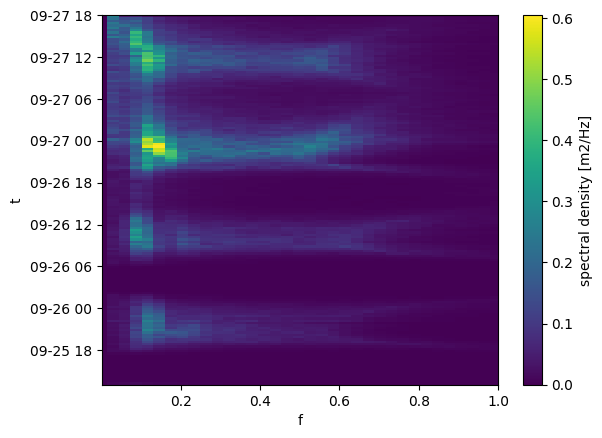

In [11]:
ds.vy.plot()
plt.xlim([1e-3, 1])
# plt.xscale('log')


(0.001, 1.0)

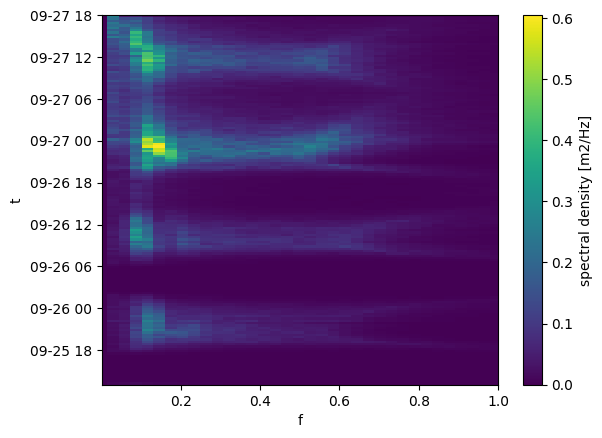

In [12]:
ds.vy.plot()
plt.xlim([1e-3, 1])
# plt.xscale('log')

<xarray.DataArray 't' ()> Size: 8B
array('2024-09-26T09:31:51.350000000', dtype='datetime64[ns]')
Coordinates:
    t        datetime64[ns] 8B 2024-09-26T09:31:51.350000


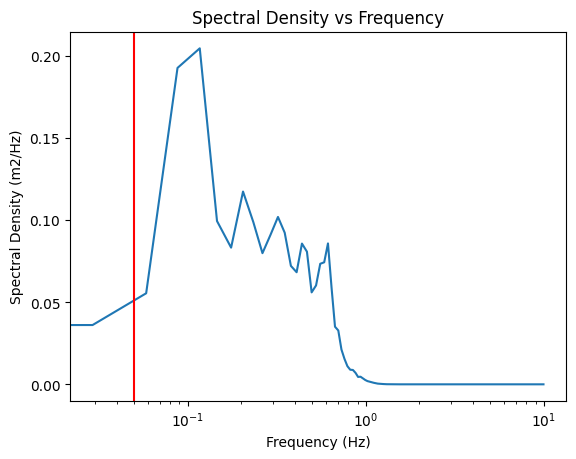

In [13]:
# Select a specific slice of ds.vy (e.g., the first slice)
vy_slice = ds.vy.isel(t=60)
print(ds.t[60])
# Plot the data
plt.figure()
plt.plot(ds.f, vy_slice)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Spectral Density (m2/Hz)')
plt.title('Spectral Density vs Frequency')
# plt.xlim(0,2)
plt.xscale('log')
plt.axvline(0.05, color='red')
plt.show()